<a href="https://colab.research.google.com/github/vishalaadee/Segmentation-Self-Driving-Cars/blob/main/segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)
    
rgb_dir= '/content/drive/MyDrive/Classroom/cvc/CameraRGB'
seg_dir= '/content/drive/MyDrive/Classroom/cvc/CameraSeg'
images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

import random
val_samples = 800
images=[]
annotations=[]
for i in range(1000):
    img1,mask1= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])[:,:,2]
    img1=cv2.resize(img1,(256,256))
    mask1=cv2.resize(mask1,(256,256,))
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)

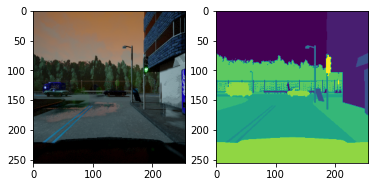

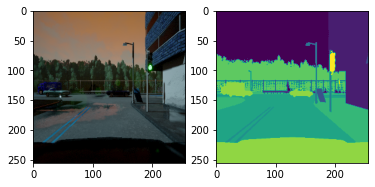

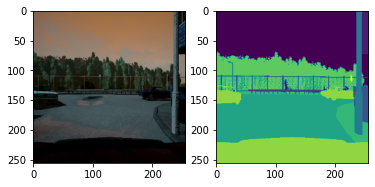

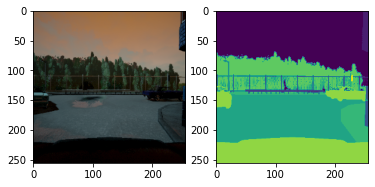

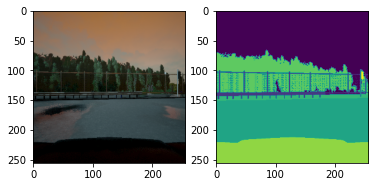

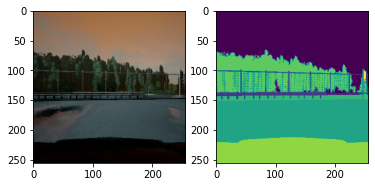

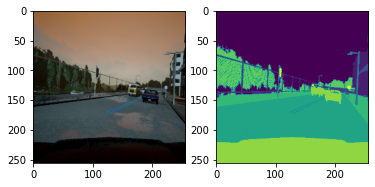

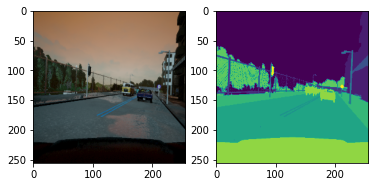

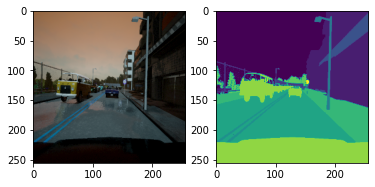

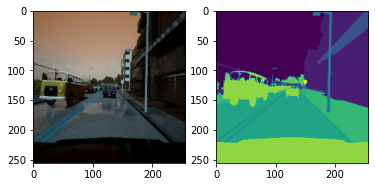

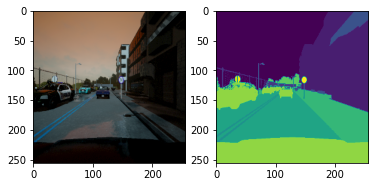

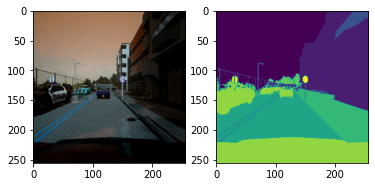

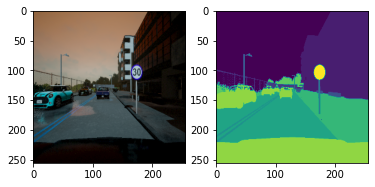

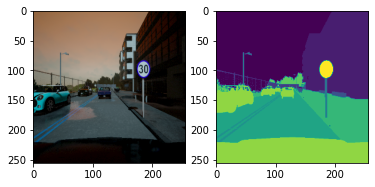

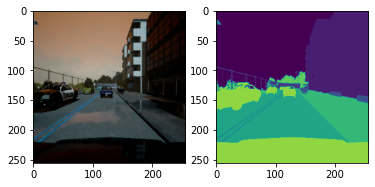

In [4]:
for i in range(80,95):
    plotter(images[i],annotations[i])

In [5]:
random.Random(900).shuffle(images)
random.Random(900).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]

In [6]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

     
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) 
        previous_block_activation = x 
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x 

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


In [7]:
keras.backend.clear_session()
model = get_model((256,256), 13)
model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("carlasimu.h5", save_best_only=True),
]

epochs = 15

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
history=model.fit(images,annotations,batch_size=32, epochs = 70 ,callbacks=callbacks,validation_split=0.2)


Epoch 1/70
25/25 [==============================] - 69s 1s/step - loss: 6.2340 - accuracy: 0.5043 - val_loss: 5.1070 - val_accuracy: 0.1420
Epoch 2/70
25/25 [==============================] - 27s 1s/step - loss: 0.8746 - accuracy: 0.7600 - val_loss: 2.3250 - val_accuracy: 0.3054
Epoch 3/70
25/25 [==============================] - 28s 1s/step - loss: 0.7902 - accuracy: 0.7752 - val_loss: 2.7099 - val_accuracy: 0.2987
Epoch 4/70
25/25 [==============================] - 27s 1s/step - loss: 0.5881 - accuracy: 0.8307 - val_loss: 2.8823 - val_accuracy: 0.3399
Epoch 5/70
25/25 [==============================] - 27s 1s/step - loss: 0.5240 - accuracy: 0.8488 - val_loss: 3.1583 - val_accuracy: 0.3017
Epoch 6/70
25/25 [==============================] - 27s 1s/step - loss: 0.4795 - accuracy: 0.8618 - val_loss: 2.6980 - val_accuracy: 0.2943
Epoch 7/70
25/25 [==============================] - 28s 1s/step - loss: 0.4878 - accuracy: 0.8617 - val_loss: 3.3000 - val_accuracy: 0.3236
Epoch 8/70
25/25 [==

(1, 256, 256, 13)
[[[[8.14993493e-03 9.62938190e-01 1.48561671e-02 ... 3.43812106e-04
    9.70633046e-05 9.41949955e-04]
   [3.81605932e-03 9.87233639e-01 6.86405785e-03 ... 1.94176573e-05
    2.88311799e-06 6.44155298e-05]
   [2.89973244e-03 9.91410196e-01 4.55628475e-03 ... 1.66575119e-05
    2.64875916e-06 2.13181684e-05]
   ...
   [9.99250591e-01 3.52844858e-04 3.26984045e-05 ... 2.93756261e-06
    1.65295205e-05 4.41320935e-07]
   [9.98571754e-01 6.13872660e-04 4.32088636e-05 ... 7.06878473e-06
    2.99056828e-05 7.97169264e-07]
   [9.90075529e-01 3.41853988e-03 4.66078520e-04 ... 7.99647823e-05
    7.13520218e-04 7.98627752e-06]]

  [[7.74650695e-03 9.80087459e-01 3.49032599e-03 ... 4.78795700e-05
    2.78934778e-04 1.64361962e-04]
   [2.11035996e-03 9.95661199e-01 1.47038989e-03 ... 1.53493954e-06
    1.40441375e-06 2.37453742e-06]
   [1.26876798e-03 9.97905374e-01 5.27860189e-04 ... 9.76234446e-07
    8.35470814e-07 4.10024057e-07]
   ...
   [9.99800384e-01 1.18165088e-04 5.506

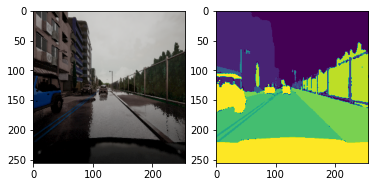

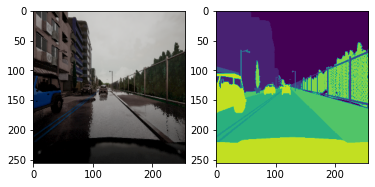

In [9]:
test = images[84]
getshape=test.shape
pred = model.predict(test.reshape(1,getshape[0],getshape[1],getshape[2]))

print(pred.shape)        
newimg = np.zeros((256,256))
print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.5:
                newimg[j,k] = i

plotter(test,newimg)
plotter(test,annotations[84])